The Approach
-----------

When constructing simple models such as wedges is it useful to apply some frequency dependent function, M(f), during creation of our synthetic in order to incorporate the effects of attenuation and dispersion?

i.e. if we are constructing seismic sections of wedges such that a seismic trace is constructed from a wavelet, w(t), and a reflectivity series r(t), then the seismic trace is:

    s(t) = w(t).r(t)

Where . is convolution

We can do this in the frequency domain as:

    W(f) = F{w(t)}
    R(f) = F{r(t)}
    S(f) = W(f)R(f)
    s(t) = F'{S(f)}
    
where F{}, F'{} are the forward and inverse fourier transforms.

So, generating w(t) and r(t)

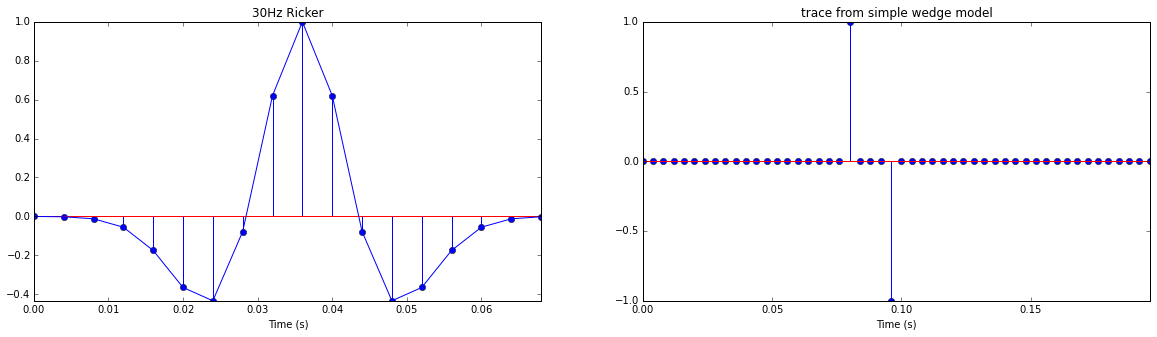

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import os, sys
import bruges
import numpy as np

plt.figure(figsize=(20,5))

#  4ms sampling
Fs = 250
dt = 1/Fs

# 30Hz Ricker wavelet
ricker = bruges.filters.wavelets.ricker
w = ricker(0.072, dt, 30)

plt.subplot(121)
plt.stem(dt*np.array(range(0,len(w))), w)
plt.plot(dt*np.array(range(0,len(w))), w)
plt.xlabel('Time (s)')
plt.axis('tight')
plt.title('30Hz Ricker')

# single trace from wedge model
t = dt*np.array(range(0, 50))
r = np.zeros_like(t)
thickness_in_samples = 4
r[20] = 1 # 80ms mark
r[20 + thickness_in_samples] = -1 # 16ms later

plt.subplot(122)
plt.stem(t,r)
plt.xlabel('Time (s)')
plt.axis('tight')
plt.title('trace from simple wedge model')

Then taking thier fourier transforms to get W(f) and R(f)

In [2]:
def plot_spectrum(X, title_stub):
    plt.figure(figsize=(20,5))
    
    plt.subplot(121)
    plt.plot(f, np.abs(X))
    plt.title(title_stub + ' - Amplitude Spectrum')
    plt.xlabel('Frequency (Hz)')
    
    plt.subplot(122)
    plt.plot(f, np.angle(X))
    plt.title(title_stub + ' - Phase Spectrum')
    plt.xlabel('Frequency (Hz)')

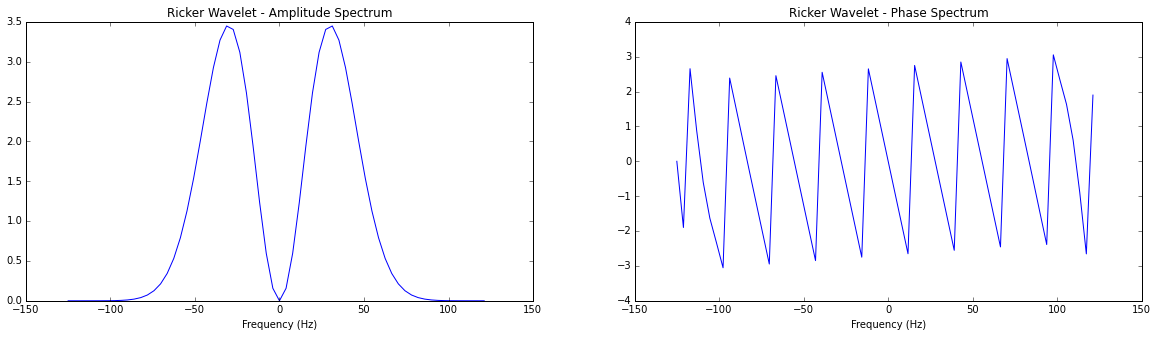

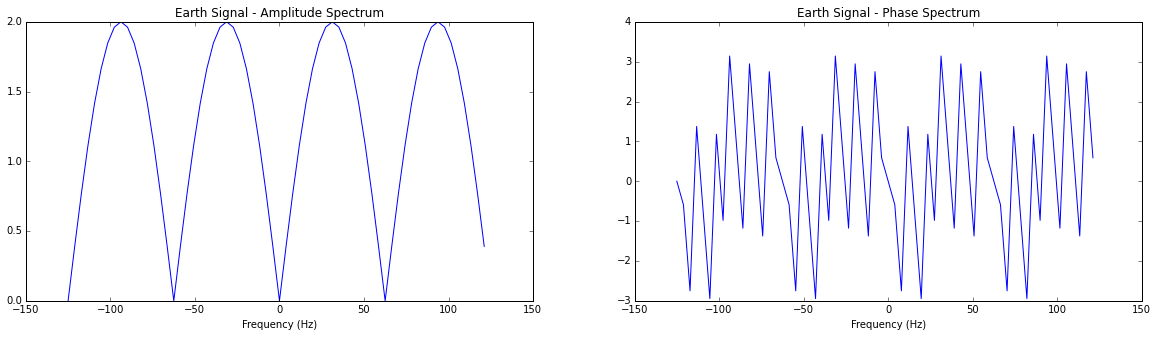

In [3]:
N = 64

f = Fs*np.fft.fftshift(np.fft.fftfreq(N))
W = np.fft.fftshift(np.fft.fft(w, N))
R = np.fft.fftshift(np.fft.fft(r, N))

plot_spectrum(W, 'Ricker Wavelet')
plot_spectrum(R, 'Earth Signal')

In [4]:
# aside: its' nice to see the notches in the amplitude spectrum
print('Notches expected at', 1/(dt*thickness_in_samples), 'Hz for time thickness of', dt*thickness_in_samples, 'seconds')

Notches expected at 62.5 Hz for time thickness of 0.016 seconds


To compute the seismic ampltiudes in the fourier domain we just multiply the spectra.

    S = W(f)R(f)

and transforming back into the time domain we have a trace from our wedge

<Container object of 3 artists>

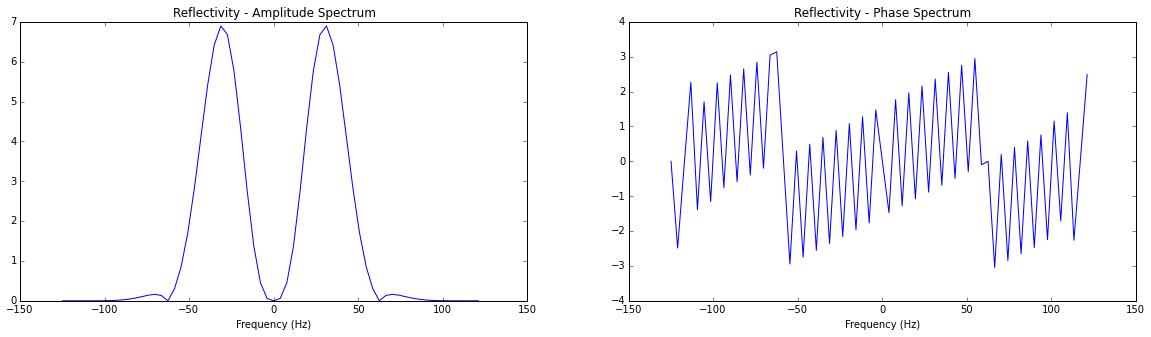

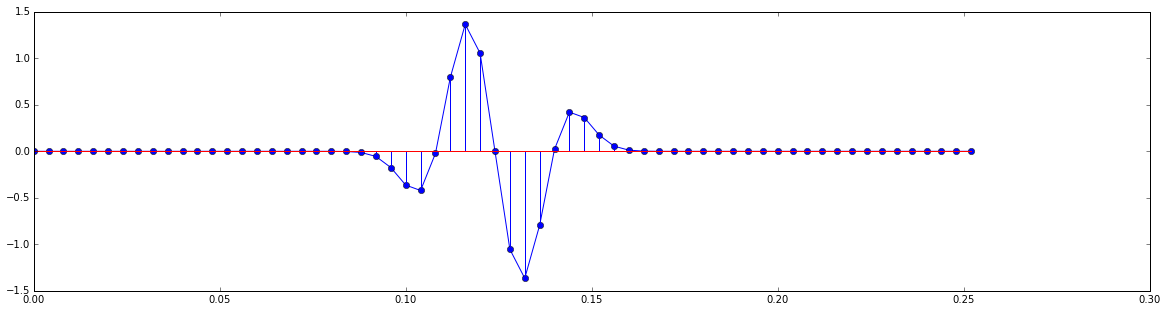

In [5]:
S = np.multiply(W,R)
plot_spectrum(S, 'Reflectivity')

s = np.fft.ifft(np.fft.fftshift(S))
plt.figure(figsize=(20,5))
plt.plot(dt*np.array(range(0,len(s))),s.real)
plt.stem(dt*np.array(range(0,len(s))),s.real)

*(NOTE: there is an additional time shift here which needs to be figured out, probably as an effect of the FD convolution)*

Adding a Frequency Dependent Effect
---------------------------------

Introducing some frequency dependent effect then becomes a matter of defining a new signal, M(f):

    S(f) = W(f)M(f)R(f)
    
so assuming that we can define M(F) appropriately, we would be applying a frequency dependent modification in bulk across the entire model.

**key questions**

 - is this a valid way to model the interation between attenuation/dispresion and the wavelet|earth signal? we are essentially introduction an additional convolutional operation.
 - are typical attenuation and dispersion profiles known? are there typical shapes/functions to these? or can they take any shape? maybe someone is already working on this...
 - can they be determined empirically? e.g. by looking at difference between estimates source wavelet and extracted wavelets at different depths?
 
Essentially, this is equivalent to modifying the wavelet w(t) to produce a new wavelet w'(t) influenced by the effects of attenutation/dispersion (A/D) (Question: is it right to call these Q effects?).

So we don't strictly need to do convolution in the frequency domain, we would just design a modified wavelet as follows.

    w'(t) = F'{ W(f)M(f) }
    
which we could also apply via time domain convolution, if we wanted to.


Defining Attenuation / Dispersion
-------------------------------

So why bother with this? well, as attenutation and dispersion are frequency dependent is would seem more tractable to define them in the frequency domain.

Fourier transforms are complex:

    M(f) = Re{M(f)} + iI{M(f)}

and can be expressed in polar form:

    M(f) = |M(f)|Cos(angle(M(f))) + i|M(f)|Sin(angle(M(f)))

 - attenutation could be modelled by varying the magnitude component |M(f)|
 - dispersion could be modelled by varying the phase component phase(M(f))
 
**Key Question**: is this take on A/D correct?
**Key Question**: are frequency dependent profiles for A/D known? can we usefully approximate them?


This is probably the simplest possible case. Some smooth attenuation function with zero phase response. (I am not sure if this should be zero or linear phase at the moment)

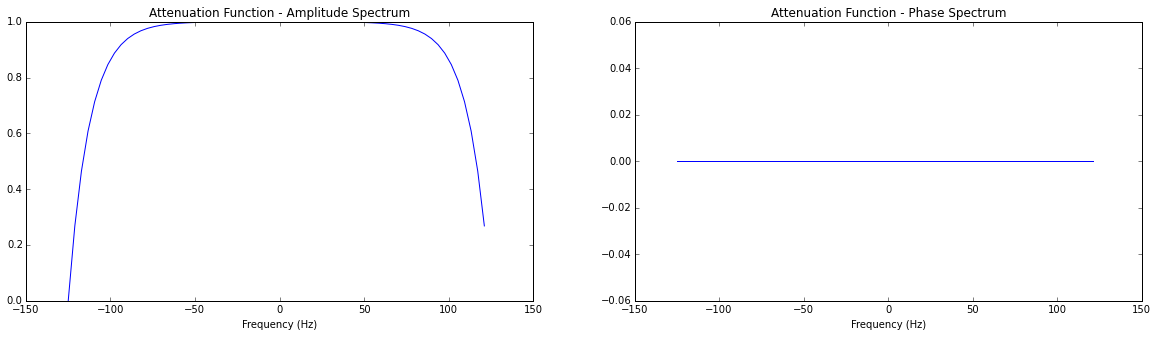

In [16]:
import math
alpha = 10
max_freq = np.amax(np.abs(f))
abs_M = 1 - np.exp(alpha*(np.abs(f)/max_freq))/math.exp(alpha)


phase_M = np.zeros_like(f)


M = np.zeros_like(f, dtype=complex)

M.real = np.multiply(abs_M, np.cos(phase_M))
M.imag = np.multiply(abs_M, np.sin(phase_M))

plot_spectrum(M, 'Attenuation Function')

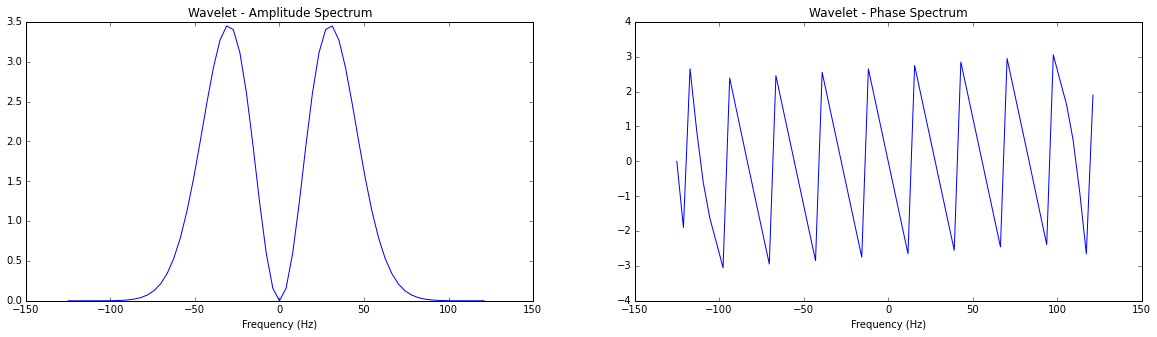

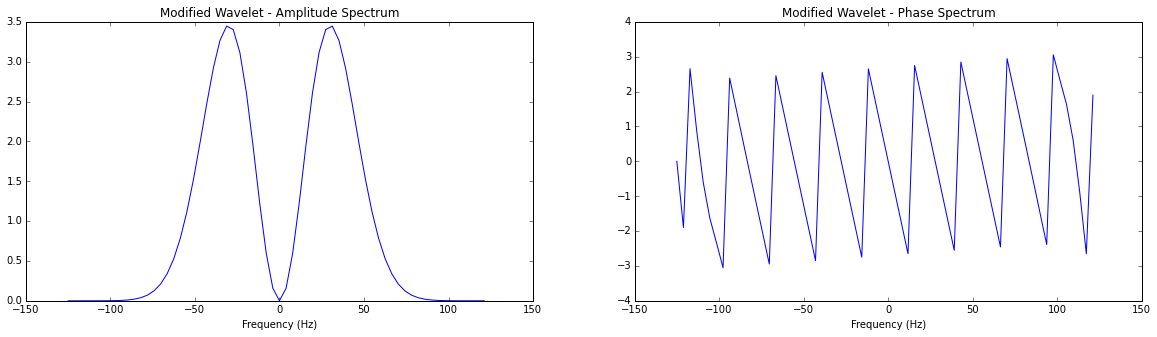

In [17]:
W_mod = np.multiply(M, W)

plot_spectrum(W, 'Wavelet')
plot_spectrum(W_mod, 'Modified Wavelet')


(-1, 1)

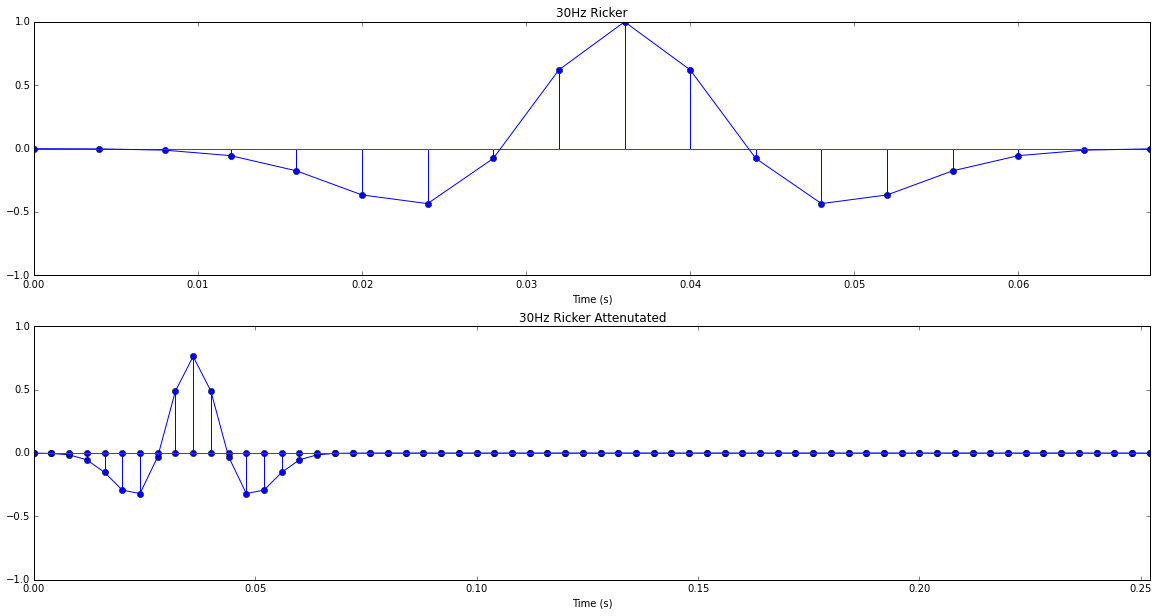

In [14]:
w_mod = np.fft.ifft(np.fft.fftshift(W_mod))

w_len = len(w)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.stem(dt*np.array(range(0,w_len)), w)
plt.plot(dt*np.array(range(0,w_len)), w)
plt.xlabel('Time (s)')
plt.axis('tight')
plt.title('30Hz Ricker')
plt.ylim((-1,1))

plt.subplot(212)
plt.stem(dt*np.array(range(0,len(w_mod))), w_mod.real)
plt.plot(dt*np.array(range(0,len(w_mod))), w_mod.real)
plt.stem(dt*np.array(range(0,len(w_mod))), w_mod.imag, 'r')
plt.plot(dt*np.array(range(0,len(w_mod))), w_mod.imag, 'r')
plt.xlabel('Time (s)')
plt.axis('tight')
plt.title('30Hz Ricker Attenutated')
plt.ylim((-1,1))


 
A/D in the overburden
--------------------

The immediate drawback with this approach is that the A/D effects are applied right across the wedge. We are not modelling A/D within the layer itself. 

This is where the approach falls well short of a full poro-elastic wavefield simulation, essentially we are modelling the effects of A/D in the overburden on the response of the wedge.
